 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="http://localhost:8888/notebooks/rnn.ipynb#Set-up-data" data-toc-modified-id="Set-up-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Set up data</a></span></li><li><span><a href="http://localhost:8888/notebooks/rnn.ipynb#RNNs-with-only-temperature-data" data-toc-modified-id="RNNs-with-only-temperature-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>RNNs with only temperature data</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/rnn.ipynb#RNN-predicting-only-the-last-target" data-toc-modified-id="RNN-predicting-only-the-last-target-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>RNN predicting only the last target</a></span></li><li><span><a href="http://localhost:8888/notebooks/rnn.ipynb#Sequence-RNN" data-toc-modified-id="Sequence-RNN-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Sequence RNN</a></span></li><li><span><a href="http://localhost:8888/notebooks/rnn.ipynb#Longer-sequence" data-toc-modified-id="Longer-sequence-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Longer sequence</a></span></li><li><span><a href="http://localhost:8888/notebooks/rnn.ipynb#Add-dropout" data-toc-modified-id="Add-dropout-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Add dropout</a></span></li><li><span><a href="http://localhost:8888/notebooks/rnn.ipynb#Reference-experiment-with-longer-training-set." data-toc-modified-id="Reference-experiment-with-longer-training-set.-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Reference experiment with longer training set.</a></span></li><li><span><a href="http://localhost:8888/notebooks/rnn.ipynb#Sequence-model-with-longer-training-set" data-toc-modified-id="Sequence-model-with-longer-training-set-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Sequence model with longer training set</a></span></li></ul></li><li><span><a href="http://localhost:8888/notebooks/rnn.ipynb#Get-additional-variables" data-toc-modified-id="Get-additional-variables-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Get additional variables</a></span></li><li><span><a href="http://localhost:8888/notebooks/rnn.ipynb#Combining-with-embeddings" data-toc-modified-id="Combining-with-embeddings-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Combining with embeddings</a></span></li><li><span><a href="http://localhost:8888/notebooks/rnn.ipynb#Embedding-with-only-temperature" data-toc-modified-id="Embedding-with-only-temperature-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Embedding with only temperature</a></span></li><li><span><a href="http://localhost:8888/notebooks/rnn.ipynb#Add-previous-forecasts-and-observations-as-features" data-toc-modified-id="Add-previous-forecasts-and-observations-as-features-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Add previous forecasts and observations as features</a></span></li></ul></div>

# Recurrent neural networks

In this notebook we will try out RNNs for our post-processing. The idea here is that there might be some extra information in looking at data from previous time steps.

RNNs take quite a long time to train, so I am using a GPU here.

In [1]:
# Imports
from importlib import reload
import utils; reload(utils)
from utils import *
import keras_models; reload(keras_models)
from keras_models import *
import losses; reload(losses)
from losses import crps_cost_function, crps_cost_function_seq
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras.layers import Input, Dense, merge, Embedding, Flatten, Dropout, \
    SimpleRNN, LSTM, TimeDistributed, GRU, Dropout, Masking
from keras.layers.merge import Concatenate
from keras.models import Model, Sequential
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD, Adam

Using TensorFlow backend.


Anaconda environment: py36_keras
Darwin 17.2.0
Anaconda environment: py36_keras
Darwin 17.2.0


In [2]:
# Use this if you want to limit the GPU RAM usage
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

In [2]:
# Basic setup
DATA_DIR = '/Volumes/STICK/data/ppnn_data/'  # Mac
# DATA_DIR = '/project/meteo/w2w/C7/ppnn_data/'   # LMU
results_dir = '../results/'
window_size = 25   # Days in rolling window
fclt = 48   # Forecast lead time in hours

## Set up data

This is now also done inside the `get_train_test_sets` function. `seq_len` is the number of timesteps (including the one to predict). We will start out with a moderate length of 5 days, training for 2015, predicting for 2016.

In [4]:
seq_len=5

In [73]:
train_dates = ['2015-01-01', '2016-01-01']
test_dates =  ['2016-01-01', '2017-01-01']
train_set, test_set = get_train_test_sets(DATA_DIR, train_dates, test_dates, 
                                          seq_len=seq_len, fill_value=-999.)

train set contains 365 days
test set contains 366 days


In [74]:
train_set.features.shape, train_set.targets.shape

((180849, 5, 2), (180849, 5, 1))

The arrays have dimensions [sample, time step, feature]

## RNNs with only temperature data

As a comparison. Our simple networks got a train/test loss of around 1.07/1.01.

I am using a Gated Recurrent Unit (GRU) as my recurrent layer. LSTM is probably the more common one, but GRU is slightly cheaper and for our simple applications provides similar results. 

### RNN predicting only the last target

In [75]:
batch_size = 1024
hidden_nodes = 100   # Number of hidden nodes inside RNN cell

In [76]:
inp = Input(shape=(seq_len, 2, )) # time step, feature
x = GRU(hidden_nodes)(inp)
x = Dense(2, activation='linear')(x)
rnn_model = Model(inputs=inp, outputs=x)

In [77]:
rnn_model.compile(optimizer=Adam(0.01), loss=crps_cost_function)

In [78]:
rnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 5, 2)              0         
_________________________________________________________________
gru_3 (GRU)                  (None, 100)               30900     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 202       
Total params: 31,102
Trainable params: 31,102
Non-trainable params: 0
_________________________________________________________________


In [79]:
rnn_model.fit(train_set.features, train_set.targets[:,-1], epochs=10, batch_size=batch_size,
              validation_data=(test_set.features, test_set.targets[:,-1]))

Train on 180849 samples, validate on 182218 samples
Epoch 1/10
180849/180849 [==============================] - 4s - loss: 1.8537 - val_loss: 1.0207
Epoch 2/10
180849/180849 [==============================] - 3s - loss: 1.0508 - val_loss: 1.0188
Epoch 3/10
180849/180849 [==============================] - 3s - loss: 1.0394 - val_loss: 1.0122
Epoch 4/10
180849/180849 [==============================] - 3s - loss: 1.0360 - val_loss: 1.0078
Epoch 5/10
180849/180849 [==============================] - 3s - loss: 1.0333 - val_loss: 1.0066
Epoch 6/10
180849/180849 [==============================] - 3s - loss: 1.0287 - val_loss: 1.0079
Epoch 7/10
180849/180849 [==============================] - 3s - loss: 1.0280 - val_loss: 1.0193
Epoch 8/10
180849/180849 [==============================] - 3s - loss: 1.0236 - val_loss: 1.0325
Epoch 9/10
180849/180849 [==============================] - 3s - loss: 1.0190 - val_loss: 1.0185
Epoch 10/10
180849/180849 [==============================] - 3s - loss: 1.0

So we get a better train score and a worse validation score. This indicates overfitting. 

### Sequence RNN

In [80]:
inp = Input(shape=(seq_len, 2, )) # time step, feature
x = GRU(hidden_nodes, return_sequences=True)(inp)
x = TimeDistributed(Dense(2, activation='linear'))(x)
seq_rnn_model = Model(inputs=inp, outputs=x)

In [81]:
seq_rnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 5, 2)              0         
_________________________________________________________________
gru_4 (GRU)                  (None, 5, 100)            30900     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 2)              202       
Total params: 31,102
Trainable params: 31,102
Non-trainable params: 0
_________________________________________________________________


In [82]:
seq_rnn_model.compile(optimizer=Adam(0.01), loss=crps_cost_function_seq, 
                      sample_weight_mode="temporal")

In [148]:
def train_and_valid(model, train_set, test_set, epochs, batch_size, verbose=0, emb=False):
    """Write our own function to train and validate, 
    because the keras fit function cannot handle sample weights for training
    and validation at the same time.
    """
    train_inp = [train_set.features, train_set.cont_ids] if emb else train_set.features
    test_inp = [test_set.features, test_set.cont_ids] if emb else test_set.features
    for i in range(epochs):
        print('Epoch:', i+1)
        t1 = timeit.default_timer()
        
        h = model.fit(train_inp, train_set.targets, epochs=1, batch_size=batch_size, 
                      sample_weight=train_set.sample_weights, verbose=verbose)
        t2 = timeit.default_timer()
        print('Train loss: %.4f - Valid loss: %.4f - Time: %.1fs' % (h.history['loss'][0],  
                    model.evaluate(test_inp, test_set.targets, batch_size=10000, 
                       sample_weight=test_set.sample_weights, verbose=verbose), 
                    t2 - t1))

In [88]:
train_and_valid(seq_rnn_model, train_set, test_set, 10, batch_size)

Epoch: 1
Train loss: 1.0207 - Valid loss: 1.0338
Epoch: 2
Train loss: 1.0179 - Valid loss: 1.0420
Epoch: 3
Train loss: 1.0173 - Valid loss: 1.0316
Epoch: 4
Train loss: 1.0161 - Valid loss: 1.0381
Epoch: 5
Train loss: 1.0135 - Valid loss: 1.0471
Epoch: 6
Train loss: 1.0123 - Valid loss: 1.0401
Epoch: 7
Train loss: 1.0117 - Valid loss: 1.0343
Epoch: 8
Train loss: 1.0089 - Valid loss: 1.0547
Epoch: 9
Train loss: 1.0078 - Valid loss: 1.0515
Epoch: 10
Train loss: 1.0064 - Valid loss: 1.0479


Same as with the first RNN above we seem to overfit to the dataset, but maybe not as strongly. Let's now try a more complex model with a longer sequence length.

### Longer sequence

In [112]:
seq_len = 20
train_dates = ['2015-01-01', '2016-01-01']
test_dates =  ['2016-01-01', '2017-01-01']
train_set, test_set = get_train_test_sets(DATA_DIR, train_dates, test_dates, 
                                          seq_len=seq_len, fill_value=-999.)

train set contains 365 days
test set contains 366 days


In [90]:
hidden_nodes = 200

In [91]:
inp = Input(shape=(seq_len, 2, )) # time step, feature
x = GRU(hidden_nodes, return_sequences=True)(inp)
x = TimeDistributed(Dense(2, activation='linear'))(x)
seq_rnn_model = Model(inputs=inp, outputs=x)

In [92]:
seq_rnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 20, 2)             0         
_________________________________________________________________
gru_5 (GRU)                  (None, 20, 200)           121800    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 2)             402       
Total params: 122,202
Trainable params: 122,202
Non-trainable params: 0
_________________________________________________________________


In [93]:
seq_rnn_model.compile(optimizer=Adam(0.01), loss=crps_cost_function_seq, 
                      sample_weight_mode="temporal")

In [94]:
train_and_valid(seq_rnn_model, train_set, test_set, 10, batch_size)

Epoch: 1
Train loss: 1.7379 - Valid loss: 1.0252
Epoch: 2
Train loss: 1.0267 - Valid loss: 1.0240
Epoch: 3
Train loss: 1.0123 - Valid loss: 1.0222
Epoch: 4
Train loss: 0.9968 - Valid loss: 1.0459
Epoch: 5
Train loss: 0.9759 - Valid loss: 1.0582
Epoch: 6
Train loss: 0.9524 - Valid loss: 1.0647
Epoch: 7
Train loss: 0.9270 - Valid loss: 1.0764
Epoch: 8
Train loss: 0.9082 - Valid loss: 1.0816
Epoch: 9
Train loss: 0.8912 - Valid loss: 1.1043
Epoch: 10
Train loss: 0.8779 - Valid loss: 1.0920


So again we are overfitting, but maybe there is something to be learned. Let's first add some regularization and then try a longer training set.

### Add dropout

In [95]:
inp = Input(shape=(seq_len, 2, )) # time step, feature
x = GRU(hidden_nodes, return_sequences=True, recurrent_dropout=0.5)(inp)
x = TimeDistributed(Dense(2, activation='linear'))(x)
seq_rnn_model = Model(inputs=inp, outputs=x)
seq_rnn_model.compile(optimizer=Adam(0.001), loss=crps_cost_function_seq, 
                      sample_weight_mode="temporal")

In [97]:
train_and_valid(seq_rnn_model, train_set, test_set, 10, batch_size)

Epoch: 1
Train loss: 1.0384 - Valid loss: 1.0048
Epoch: 2
Train loss: 1.0361 - Valid loss: 1.0030
Epoch: 3
Train loss: 1.0342 - Valid loss: 1.0019
Epoch: 4
Train loss: 1.0332 - Valid loss: 1.0035
Epoch: 5
Train loss: 1.0319 - Valid loss: 1.0027
Epoch: 6
Train loss: 1.0309 - Valid loss: 1.0033
Epoch: 7
Train loss: 1.0301 - Valid loss: 1.0073
Epoch: 8
Train loss: 1.0290 - Valid loss: 1.0035
Epoch: 9
Train loss: 1.0284 - Valid loss: 1.0086
Epoch: 10
Train loss: 1.0278 - Valid loss: 1.0054


So with drop out we get slightly better validation results, but we are still starting to overfit. I think there is a lot of parameter tuning that would be possible with the complexity of the network and so forth. 

### Reference experiment with longer training set.

In [98]:
train_dates_long = ['2008-01-01', '2016-01-01']
train_set, test_set = get_train_test_sets(DATA_DIR, train_dates_long, test_dates)

train set contains 2922 days
test set contains 366 days


In [99]:
# Copied from fc_network notebook
def build_fc_model():
    inp = Input(shape=(2,))
    x = Dense(2, activation='linear')(inp)
    return Model(inputs=inp, outputs=x)

In [100]:
fc_model = build_fc_model()
fc_model.compile(optimizer=Adam(0.1), loss=crps_cost_function)

In [101]:
fc_model.fit(train_set.features, train_set.targets, epochs=10, batch_size=1024,
             validation_data=[test_set.features, test_set.targets])

Train on 1456977 samples, validate on 182218 samples
Epoch 1/10
1456977/1456977 [==============================] - 6s - loss: 1.3737 - val_loss: 1.0100
Epoch 2/10
1456977/1456977 [==============================] - 5s - loss: 1.0626 - val_loss: 1.0109
Epoch 3/10
1456977/1456977 [==============================] - 5s - loss: 1.0628 - val_loss: 1.0079
Epoch 4/10
1456977/1456977 [==============================] - 5s - loss: 1.0630 - val_loss: 1.0126
Epoch 5/10
1456977/1456977 [==============================] - 5s - loss: 1.0630 - val_loss: 1.0109
Epoch 6/10
1456977/1456977 [==============================] - 5s - loss: 1.0630 - val_loss: 1.0074
Epoch 7/10
1456977/1456977 [==============================] - 5s - loss: 1.0629 - val_loss: 1.0119
Epoch 8/10
1456977/1456977 [==============================] - 5s - loss: 1.0630 - val_loss: 1.0130
Epoch 9/10
1456977/1456977 [==============================] - 5s - loss: 1.0630 - val_loss: 1.0082
Epoch 10/10
1456977/1456977 [===========================

Maybe a small improvement. Now let's test our sequence model with a longer training period.

### Sequence model with longer training set

In [102]:
seq_len = 20
train_set, test_set = get_train_test_sets(DATA_DIR, train_dates_long, test_dates, 
                                          seq_len=seq_len, fill_value=-999.)

train set contains 2922 days
test set contains 366 days


In [107]:
def build_seq_rnn(hidden_nodes, n_features, dropout=0, lr=0.01):
    inp = Input(shape=(seq_len, n_features, )) # time step, feature
    x = GRU(hidden_nodes, return_sequences=True, recurrent_dropout=dropout)(inp)
    x = TimeDistributed(Dense(2, activation='linear'))(x)
    seq_rnn_model = Model(inputs=inp, outputs=x)
    seq_rnn_model.compile(optimizer=Adam(lr), loss=crps_cost_function_seq, 
                          sample_weight_mode="temporal")
    return seq_rnn_model

In [104]:
inp = Input(shape=(seq_len, 2, )) # time step, feature
x = GRU(hidden_nodes, return_sequences=True, recurrent_dropout=0.5)(inp)
x = TimeDistributed(Dense(2, activation='linear'))(x)
seq_rnn_model = Model(inputs=inp, outputs=x)
seq_rnn_model.compile(optimizer=Adam(0.001), loss=crps_cost_function_seq, 
                      sample_weight_mode="temporal")

In [106]:
# This takes several minutes on the GPU
# Epoch counter: 7
train_and_valid(seq_rnn_model, train_set, test_set, 2, batch_size)

Epoch: 1
Train loss: 1.0349 - Valid loss: 0.9941
Epoch: 2
Train loss: 1.0333 - Valid loss: 0.9959


## Get additional variables

In [109]:
from collections import OrderedDict
aux_dict = OrderedDict()
aux_dict['data_aux_geo_interpolated.nc'] = ['orog', 
                                            'station_alt', 
                                            'station_lat', 
                                            'station_lon']
aux_dict['data_aux_pl500_interpolated_00UTC.nc'] = ['u_pl500_fc',
                                                    'v_pl500_fc',
                                                    'gh_pl500_fc']
aux_dict['data_aux_pl850_interpolated_00UTC.nc'] = ['u_pl850_fc',
                                                    'v_pl850_fc',
                                                    'q_pl850_fc']
aux_dict['data_aux_surface_interpolated_00UTC.nc'] = ['cape_fc',
                                                      'sp_fc',
                                                      'tcc_fc']

In [157]:
# Start with just one training year
train_set, test_set = get_train_test_sets(DATA_DIR, train_dates, test_dates, 
                                          seq_len=seq_len, fill_value=-999., aux_dict=aux_dict)

train set contains 365 days
test set contains 366 days


In [158]:
train_set.cont_ids.shape

(180849, 20)

In [111]:
n_features = train_set.features.shape[-1]
n_features

24

In [114]:
seq_rnn_model = build_seq_rnn(hidden_nodes, n_features, dropout=0.5, lr=0.01)

In [121]:
# Epoch counter: 8
train_and_valid(seq_rnn_model, train_set, test_set, 2, batch_size, verbose=1)

Epoch: 1
Epoch 1/1
182218/182218 [==============================] - 6s     
Train loss: 0.8329 - Valid loss: 0.9341 - Time: 18.1s
Epoch: 2
Epoch 1/1
182218/182218 [==============================] - 6s     
Train loss: 0.8201 - Valid loss: 0.9315 - Time: 18.1s


In [131]:
seq_rnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 20, 24)            0         
_________________________________________________________________
gru_9 (GRU)                  (None, 20, 200)           135000    
_________________________________________________________________
time_distributed_6 (TimeDist (None, 20, 2)             402       
Total params: 135,402
Trainable params: 135,402
Non-trainable params: 0
_________________________________________________________________


## Combining with embeddings

In [187]:
def build_seq_rnn_with_embeddings(seq_len, hidden_nodes, n_features, emb_size, max_id, 
                                  recurrent_dropout=0, dropout=0, lr=0.01):
    features_inp = Input(shape=(seq_len, n_features, )) # time step, feature
    id_in = Input(shape=(seq_len,))
    emb = Embedding(max_id + 1, emb_size)(id_in)
    x = GRU(hidden_nodes, return_sequences=True, recurrent_dropout=recurrent_dropout)(features_inp)
    x = Concatenate()([x, emb])
    x = Dropout(dropout)(x)
    x = TimeDistributed(Dense(2, activation='linear'))(x)
    model = Model(inputs=[features_inp, id_in], outputs=x)
    model.compile(optimizer=Adam(lr), loss=crps_cost_function_seq, 
                          sample_weight_mode="temporal")
    return model

In [163]:
emb_size = 5
max_id = int(np.max([train_set.cont_ids.max(), test_set.cont_ids.max()]))
hidden_nodes, max_id

(200, 536)

In [164]:
emb_rnn = build_seq_rnn_with_embeddings(hidden_nodes, n_features, emb_size, max_id, 0.5)

In [165]:
emb_rnn.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_24 (InputLayer)            (None, 20, 24)        0                                            
____________________________________________________________________________________________________
input_25 (InputLayer)            (None, 20)            0                                            
____________________________________________________________________________________________________
gru_16 (GRU)                     (None, 20, 200)       135000      input_24[0][0]                   
____________________________________________________________________________________________________
embedding_8 (Embedding)          (None, 20, 5)         2685        input_25[0][0]                   
___________________________________________________________________________________________

In [167]:
train_and_valid(emb_rnn, train_set, test_set, 5, batch_size, emb=True)

Epoch: 1
Train loss: 0.9147 - Valid loss: 0.8970 - Time: 19.6s
Epoch: 2
Train loss: 0.9016 - Valid loss: 0.8984 - Time: 19.7s
Epoch: 3
Train loss: 0.8923 - Valid loss: 0.9004 - Time: 19.6s
Epoch: 4
Train loss: 0.8822 - Valid loss: 0.9023 - Time: 19.6s
Epoch: 5
Train loss: 0.8737 - Valid loss: 0.8983 - Time: 19.6s


## Embedding with only temperature

In [182]:
train_set, test_set = get_train_test_sets(DATA_DIR, train_dates, test_dates, 
                                          seq_len=2, fill_value=-999.)

train set contains 365 days
test set contains 366 days


In [191]:
emb_rnn = build_seq_rnn_with_embeddings(2, 10, 2, emb_size, max_id, recurrent_dropout=0)

In [192]:
emb_rnn.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_36 (InputLayer)            (None, 2, 2)          0                                            
____________________________________________________________________________________________________
input_37 (InputLayer)            (None, 2)             0                                            
____________________________________________________________________________________________________
gru_22 (GRU)                     (None, 2, 10)         390         input_36[0][0]                   
____________________________________________________________________________________________________
embedding_14 (Embedding)         (None, 2, 5)          2685        input_37[0][0]                   
___________________________________________________________________________________________

In [198]:
train_and_valid(emb_rnn, train_set, test_set, 5, batch_size, emb=True)

Epoch: 1
Train loss: 0.9538 - Valid loss: 0.9194 - Time: 1.2s
Epoch: 2
Train loss: 0.9534 - Valid loss: 0.9233 - Time: 1.1s
Epoch: 3
Train loss: 0.9541 - Valid loss: 0.9263 - Time: 1.1s
Epoch: 4
Train loss: 0.9538 - Valid loss: 0.9229 - Time: 1.2s
Epoch: 5
Train loss: 0.9536 - Valid loss: 0.9233 - Time: 1.1s


In [200]:
train_dates_long = ['2008-01-01', '2016-01-01']
train_set_long, test_set = get_train_test_sets(DATA_DIR, train_dates_long, test_dates, 
                                          seq_len=seq_len, fill_value=-999.)

train set contains 2922 days
test set contains 366 days


In [204]:
emb_rnn = build_seq_rnn_with_embeddings(seq_len, 30, 2, emb_size, max_id, recurrent_dropout=0.3)

In [205]:
train_and_valid(emb_rnn, train_set_long, test_set, 15, batch_size, emb=True)

Epoch: 1
Train loss: 1.2161 - Valid loss: 0.9024 - Time: 40.9s
Epoch: 2
Train loss: 0.9281 - Valid loss: 0.8962 - Time: 38.3s
Epoch: 3
Train loss: 0.9255 - Valid loss: 0.8949 - Time: 38.3s
Epoch: 4
Train loss: 0.9239 - Valid loss: 0.8965 - Time: 38.3s
Epoch: 5
Train loss: 0.9227 - Valid loss: 0.8954 - Time: 38.3s
Epoch: 6
Train loss: 0.9216 - Valid loss: 0.9010 - Time: 38.3s
Epoch: 7
Train loss: 0.9210 - Valid loss: 0.9060 - Time: 38.3s
Epoch: 8
Train loss: 0.9205 - Valid loss: 0.8914 - Time: 38.2s
Epoch: 9
Train loss: 0.9198 - Valid loss: 0.8937 - Time: 38.3s
Epoch: 10
Train loss: 0.9193 - Valid loss: 0.8931 - Time: 38.2s
Epoch: 11
Train loss: 0.9191 - Valid loss: 0.8955 - Time: 38.2s
Epoch: 12
Train loss: 0.9188 - Valid loss: 0.9047 - Time: 38.2s
Epoch: 13
Train loss: 0.9186 - Valid loss: 0.8932 - Time: 38.2s
Epoch: 14
Train loss: 0.9184 - Valid loss: 0.8945 - Time: 38.2s
Epoch: 15
Train loss: 0.9183 - Valid loss: 0.8993 - Time: 38.2s


## Add previous forecasts and observations as features

Let's try a very simple form of memory. Simply adding the forecast, observation and error at the current time.

In [31]:
train_dates = ['2015-01-01', '2016-01-01']
test_dates =  ['2016-01-01', '2017-01-01']
train_set, test_set = get_train_test_sets(DATA_DIR, train_dates, test_dates,
                                          add_current_error=True)

train set contains 365 days
test set contains 366 days


In [32]:
train_set.feature_names

['t2m_fc_mean',
 't2m_fc_std',
 'curr_t2m_fc_mean',
 'curr_t2m_fc_obs',
 'curr_err']

In [33]:
train_set.features.shape

(195929, 5)

In [34]:
test_set.features[10000:11000, :]

array([[ -4.16025579e-01,   5.29616654e-01,  -9.77649316e-02,
         -5.11945412e-02,   7.73962587e-02],
       [ -2.98225224e-01,   2.79068202e-01,  -9.18984637e-02,
         -8.19112659e-02,   8.43664748e-04],
       [ -4.24173504e-01,   9.02967393e-01,  -2.06207782e-01,
         -9.55631435e-02,   1.89672261e-01],
       ..., 
       [ -2.37503141e-01,   3.89254838e-01,  -1.53460518e-01,
         -2.42320821e-01,  -2.23194495e-01],
       [ -1.56708300e-01,   2.30311200e-01,  -2.50977844e-01,
         -3.58361781e-01,  -2.84274936e-01],
       [ -3.31122875e-01,   8.02613497e-01,  -4.61168319e-01,
         -3.24232101e-01,   1.88998073e-01]], dtype=float32)

In [35]:
fc_model = build_fc_model(5, 2, compile=True)

In [36]:
# Note: I am running this cell several times 
fc_model.fit(train_set.features, train_set.targets, epochs=10, batch_size=1024,
             validation_data=[test_set.features, test_set.targets])

Train on 195929 samples, validate on 196468 samples
Epoch 1/10
195929/195929 [==============================] - 1s - loss: 2.2785 - val_loss: 1.3932
Epoch 2/10
195929/195929 [==============================] - 1s - loss: 1.2732 - val_loss: 1.1072
Epoch 3/10
195929/195929 [==============================] - 1s - loss: 1.0611 - val_loss: 0.9511
Epoch 4/10
195929/195929 [==============================] - 1s - loss: 0.9821 - val_loss: 0.9131
Epoch 5/10
195929/195929 [==============================] - 1s - loss: 0.9691 - val_loss: 0.9087
Epoch 6/10
195929/195929 [==============================] - 1s - loss: 0.9681 - val_loss: 0.9089
Epoch 7/10
195929/195929 [==============================] - 1s - loss: 0.9681 - val_loss: 0.9077
Epoch 8/10
195929/195929 [==============================] - 1s - loss: 0.9680 - val_loss: 0.9086
Epoch 9/10
195929/195929 [==============================] - 1s - loss: 0.9681 - val_loss: 0.9094
Epoch 10/10
195929/195929 [==============================] - 1s - loss: 0.9

Erm ok wow, that is pretty incredible. But wait maybe this is very similar to the embedding information.

In [7]:
emb_size = 3
max_id = int(np.max([train_set.cont_ids.max(), test_set.cont_ids.max()]))
max_id

NameError: name 'train_set' is not defined

In [38]:
emb_model = build_emb_model(5, 2, [], emb_size, max_id, compile=True,
                            lr=0.01)

In [42]:
emb_model.fit([train_set.features, train_set.cont_ids], train_set.targets, 
              epochs=10, batch_size=1024, 
              validation_data=[[test_set.features, test_set.cont_ids], test_set.targets])

Train on 195929 samples, validate on 196468 samples
Epoch 1/10
195929/195929 [==============================] - 1s - loss: 0.8947 - val_loss: 0.8393
Epoch 2/10
195929/195929 [==============================] - 1s - loss: 0.8947 - val_loss: 0.8402
Epoch 3/10
195929/195929 [==============================] - 1s - loss: 0.8946 - val_loss: 0.8397
Epoch 4/10
195929/195929 [==============================] - 1s - loss: 0.8946 - val_loss: 0.8405
Epoch 5/10
195929/195929 [==============================] - 1s - loss: 0.8946 - val_loss: 0.8414
Epoch 6/10
195929/195929 [==============================] - 1s - loss: 0.8946 - val_loss: 0.8396
Epoch 7/10
195929/195929 [==============================] - 1s - loss: 0.8946 - val_loss: 0.8393
Epoch 8/10
195929/195929 [==============================] - 1s - loss: 0.8945 - val_loss: 0.8394
Epoch 9/10
195929/195929 [==============================] - 1s - loss: 0.8945 - val_loss: 0.8400
Epoch 10/10
195929/195929 [==============================] - 1s - loss: 0.8

Alright, I need to check whether I am cheating, but for now let's try to build the best model.

In [3]:
from collections import OrderedDict
more_aux_dict = OrderedDict()
more_aux_dict['data_aux_geo_interpolated.nc'] = ['orog', 
                                            'station_alt', 
                                            'station_lat', 
                                            'station_lon']
more_aux_dict['data_aux_pl500_interpolated_00UTC.nc'] = ['u_pl500_fc',
                                                    'v_pl500_fc',
                                                    'gh_pl500_fc']
more_aux_dict['data_aux_pl850_interpolated_00UTC.nc'] = ['u_pl850_fc',
                                                    'v_pl850_fc',
                                                    'q_pl850_fc']
more_aux_dict['data_aux_surface_interpolated_00UTC.nc'] = ['cape_fc',
                                                      'sp_fc',
                                                      'tcc_fc']
more_aux_dict['data_aux_surface_more_interpolated_part1_00UTC.nc']  = [
    'sshf_fc', 'slhf_fc', 'u10_fc','v10_fc'
]
more_aux_dict['data_aux_surface_more_interpolated_part2_00UTC.nc']  = [
    'ssr_fc', 'str_fc', 'd2m_fc','sm_fc'
]

In [5]:
train_dates = ['2015-01-01', '2016-01-01']
test_dates =  ['2016-01-01', '2017-01-01']
more_train_set, more_test_set = get_train_test_sets(DATA_DIR, train_dates, test_dates,
                                         aux_dict=more_aux_dict, add_current_error=True)

train set contains 365 days
test set contains 366 days


In [8]:
emb_size = 3
max_id = int(np.max([more_train_set.cont_ids.max(), more_test_set.cont_ids.max()]))
max_id

536

In [22]:
emb_model = build_emb_model(more_train_set.features.shape[1], 2, [50], 3, max_id, 
                            compile=True, lr=0.01)

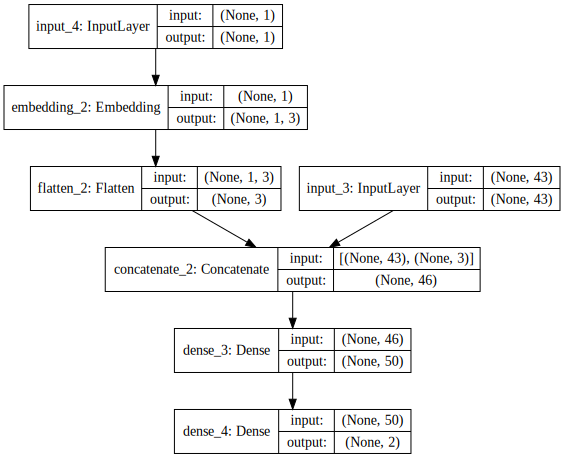

In [17]:
from IPython.display import SVG, 
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(emb_model, show_shapes=True).create(prog='dot', format='svg'))

In [23]:
emb_model.fit([more_train_set.features, more_train_set.cont_ids], more_train_set.targets, epochs=30, 
              batch_size=4096, validation_split=0.0)
              #callbacks=[EarlyStopping(monitor='val_loss', 
              #                         min_delta=0,
              #                         patience=3)])

Epoch 1/30
195929/195929 [==============================] - 1s - loss: 2.9915     
Epoch 2/30
195929/195929 [==============================] - 0s - loss: 1.4867     
Epoch 3/30
195929/195929 [==============================] - 0s - loss: 1.1565     
Epoch 4/30
195929/195929 [==============================] - 0s - loss: 1.0191     
Epoch 5/30
195929/195929 [==============================] - 0s - loss: 0.9549     
Epoch 6/30
195929/195929 [==============================] - 0s - loss: 0.9258     
Epoch 7/30
195929/195929 [==============================] - 0s - loss: 0.9055     
Epoch 8/30
195929/195929 [==============================] - 0s - loss: 0.8949     
Epoch 9/30
195929/195929 [==============================] - 0s - loss: 0.8780     
Epoch 10/30
195929/195929 [==============================] - 0s - loss: 0.8752     
Epoch 11/30
195929/195929 [==============================] - 0s - loss: 0.8520     
Epoch 12/30
195929/195929 [==============================] - 0s - loss: 0.8502     
E

In [24]:
emb_model.evaluate([more_test_set.features, more_test_set.cont_ids], more_test_set.targets, batch_size=10000)

170000/196468 [========================>.....] - ETA: 0s

0.8035658740438123

In [25]:
emb_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_6 (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_3 (Embedding)          (None, 1, 3)          1611        input_6[0][0]                    
____________________________________________________________________________________________________
input_5 (InputLayer)             (None, 43)            0                                            
____________________________________________________________________________________________________
flatten_3 (Flatten)              (None, 3)             0           embedding_3[0][0]                
___________________________________________________________________________________________

In [54]:
long_train_dates = ['2008-01-01', '2016-01-01']

In [55]:
long_more_train_set, more_test_set = get_train_test_sets(DATA_DIR, long_train_dates, test_dates,
                                                         aux_dict=more_aux_dict,
                                                        add_current_error=True)

train set contains 2922 days
test set contains 366 days


In [56]:
emb_model = build_emb_model(long_more_train_set.features.shape[1], 2, [50], 3, max_id, 
                            compile=True, lr=0.01)

In [58]:
emb_model.fit([long_more_train_set.features, long_more_train_set.cont_ids], long_more_train_set.targets, epochs=50, 
              batch_size=4096, validation_split=0.2,
              callbacks=[EarlyStopping(monitor='val_loss', 
                                       min_delta=0,
                                       patience=2)])

Train on 1255230 samples, validate on 313808 samples
Epoch 1/50
1255230/1255230 [==============================] - 5s - loss: 1.3354 - val_loss: 0.8262
Epoch 2/50
1255230/1255230 [==============================] - 4s - loss: 0.8367 - val_loss: 0.8129
Epoch 3/50
1255230/1255230 [==============================] - 4s - loss: 0.8255 - val_loss: 0.8046
Epoch 4/50
1255230/1255230 [==============================] - 4s - loss: 0.8171 - val_loss: 0.8009
Epoch 5/50
1255230/1255230 [==============================] - 4s - loss: 0.8090 - val_loss: 0.7965
Epoch 6/50
1255230/1255230 [==============================] - 4s - loss: 0.8048 - val_loss: 0.7951
Epoch 7/50
1255230/1255230 [==============================] - 4s - loss: 0.8020 - val_loss: 0.7882
Epoch 8/50
1255230/1255230 [==============================] - 4s - loss: 0.8000 - val_loss: 0.7909
Epoch 9/50
1255230/1255230 [==============================] - 4s - loss: 0.7973 - val_loss: 0.7899
Epoch 10/50
1255230/1255230 [===========================

In [59]:
emb_model.evaluate([more_test_set.features, more_test_set.cont_ids], test_set.targets, batch_size=10000)

170000/196468 [========================>.....] - ETA: 0s

0.78701121256110074